# Gomoku game

1. [DONE] Implement a Gomoku game rule class, which checks whether a position is the end of the game.
2. [DONE] Implement a greedy rule based player, which puts the stone on one of the available points where creates the maximum number of 5s, 4s, 3s and 2s, and prevent the opponent to have 5s and 4s.
3. [DONE] Implement a human player UI that can play with the greedy player.
4. [DONE] Use supervised learning to learn the greedy rule based player.
5. [DONE] Use the human player UI to play with the learned player.
6. [DONE] Implement a head-to-head evaluation to compare the performance of the learned players.
8. [DONE] Use reinforcement learning to learn a play policy against the rule based player.
7. [WIP] Use reinforcement learning to learn a play policy against itself starting from the supervise learning trained policy.
9. Use reinforcement learning to learn a play policy against itself starting from a random policy. This might take long time to converge.

In [1]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display
from typing import Tuple
from tqdm.notebook import tqdm
from abc import ABC, abstractmethod

In [2]:
NUM_IN_ROW_TO_WIN = 5
BOARD_LENGTH = 11

In [3]:
def spiral_order(length) -> torch.Tensor:
  assert length % 2 == 1, "spiral_order only works for odd length"
  spiral_order = torch.zeros([length, length], dtype=torch.int64)
  x, y = length // 2, length // 2
  dx, dy = 0, 1
  try:
    for i in range(length * length):
      spiral_order[x, y] = i + 1
      if spiral_order[x + dy, y - dx] == 0:  # x + dx >= length or x + dx < 0 or y + dy >= length or y + dy < 0 or 
        dx, dy = dy, -dx
      x, y = x + dx, y + dy
  except IndexError:
    print(f"IndexError at {x}, {y}, i={i}, spiral_order={spiral_order}")
  return spiral_order

spiral_order(BOARD_LENGTH)

tensor([[101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111],
        [100,  65,  66,  67,  68,  69,  70,  71,  72,  73, 112],
        [ 99,  64,  37,  38,  39,  40,  41,  42,  43,  74, 113],
        [ 98,  63,  36,  17,  18,  19,  20,  21,  44,  75, 114],
        [ 97,  62,  35,  16,   5,   6,   7,  22,  45,  76, 115],
        [ 96,  61,  34,  15,   4,   1,   8,  23,  46,  77, 116],
        [ 95,  60,  33,  14,   3,   2,   9,  24,  47,  78, 117],
        [ 94,  59,  32,  13,  12,  11,  10,  25,  48,  79, 118],
        [ 93,  58,  31,  30,  29,  28,  27,  26,  49,  80, 119],
        [ 92,  57,  56,  55,  54,  53,  52,  51,  50,  81, 120],
        [ 91,  90,  89,  88,  87,  86,  85,  84,  83,  82, 121]])

In [4]:
def is_win(
    position: torch.Tensor,
    point: torch.Tensor,
  ) -> bool:
  '''Check whether the position is at a terminating status.
  Args:
    position: A Tensor of shape [B, BOARD_LENGTH, BOARD_LENGTH] which has value 0, 1, and 2 for each element.
      0 means the point is not ocupied and available to play on. 1 mean that the point is taken by player 1,
      and 2 means that the point is taken by player 2.
    point: A Tensor [B, 2], which carries the 0-based row and column of the point that is last played. The
      position should be already updated with the last play, which means that position[point] should be either
      1 or 2 and cannot be 0.
  '''
  
  # check row
  x_len = 1
  for y_diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[1] + y_diff < BOARD_LENGTH and position[point[0], point[1] + y_diff] == position[point[0], point[1]]:
      x_len += 1
    else:
      break
  for y_diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[1] + y_diff >= 0 and position[point[0], point[1] + y_diff] == position[point[0], point[1]]:
      x_len += 1
    else:
      break
  if x_len >= NUM_IN_ROW_TO_WIN:
    return True
  
  # check column
  y_len = 1
  for x_diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + x_diff < BOARD_LENGTH and position[point[0] + x_diff, point[1]] == position[point[0], point[1]]:
      y_len += 1
    else:
      break
  for x_diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + x_diff >= 0 and position[point[0] + x_diff, point[1]] == position[point[0], point[1]]:
      y_len += 1
    else:
      break
  if y_len >= NUM_IN_ROW_TO_WIN:
    return True

  # check top-right bottom-left diagonal
  diag_len = 1
  for diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + diff < BOARD_LENGTH and point[1] + diff < BOARD_LENGTH and position[point[0] + diff, point[1] + diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  for diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + diff >= 0 and point[1] + diff >= 0 and position[point[0] + diff, point[1] + diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  if diag_len >= NUM_IN_ROW_TO_WIN:
    return True

  # check top-left bottom-right diagonal
  diag_len = 1
  for diff in range(1, NUM_IN_ROW_TO_WIN):
    if point[0] + diff < BOARD_LENGTH and point[1] - diff >= 0 and position[point[0] + diff, point[1] - diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  for diff in range(-1, -NUM_IN_ROW_TO_WIN, -1):
    if point[0] + diff >= 0 and point[1] - diff < BOARD_LENGTH and position[point[0] + diff, point[1] - diff] == position[point[0], point[1]]:
      diag_len += 1
    else:
      break
  if diag_len >= NUM_IN_ROW_TO_WIN:
    return True

  return False


def test_is_win():
  position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32)
  position[0, 0] = 1
  position[1, 0] = 1
  position[2, 0] = 1
  position[3, 0] = 1
  position[4, 0] = 1
  assert is_win(position, torch.tensor([4, 0]))
  position[4, 0] = 0
  position[0, 0] = 0
  position[0, 1] = 1
  position[0, 2] = 1
  position[0, 3] = 1
  position[0, 4] = 1
  position[0, 5] = 1
  assert is_win(position, torch.tensor([0, 3]))
  position[0, 0] = 1
  position[1, 1] = 1
  position[2, 2] = 1
  position[3, 3] = 1
  position[4, 4] = 1
  assert is_win(position, torch.tensor([1, 1]))
  position[4, 4] = 0
  position[5, 4] = 2
  position[6, 3] = 2
  position[7, 2] = 2
  position[8, 1] = 2
  position[9, 0] = 2
  assert is_win(position, torch.tensor([9, 0]))
  assert not is_win(position, torch.tensor([3, 0]))
  print('All test passed!')


test_is_win()

All test passed!


In [5]:
# use a spiral order to break ties
break_tie = spiral_order(BOARD_LENGTH) * -0.00001

def greedy_play(
    position: torch.Tensor,
    player: int,
) -> torch.Tensor | None:
  '''Given the current position, return the next play for the player.
  Args:
    position: A tensor of shape [BOARD_LENGTH, BOARD_LENGTH] which has value 0, 1, and 2 for each element.
      0 means the point is not ocupied and available to play on. 1 mean that the point is taken by player 1,
      and 2 means that the point is taken by player 2.
    player: An integer, 1 or 2, which indicates the player to play next.
  Returns:
    A tensor of shape [2], which carries the 0-based row and column of the point that the player should play.
    If the player cannot play anywhere, return None.
  '''
  # Score every empty point on the board:
  # For the 5 consecutive points starting from the point on one of the 4 directions (right, right-down, down, left-down):
  #   1. If the last point of the 5 is out of the board, skip.
  #   2. If both players have taken at least one of the 5 points, skip.
  #   3. If 4/3/2/1 point(s) are alreay taken by the player, score at the empty positions +100000/1000/10/1.
  #   4. If 4/3/2/1 point(s) are alreay taken by the other player, score at the empty positions +10000/100/1/0.1.
  # return the point with the highest score. If there is a tie, return the point closest to the center of the board.
  # If there is a tie, return the one with the smallest row.
  # If still tie, return the one with the smallest column.

  scores = break_tie.clone()
  for dx, dy in [(0, 1), (1, 1), (1, 0), (1, -1)]:
    counts_x = BOARD_LENGTH - (NUM_IN_ROW_TO_WIN - 1) * abs(dx)
    counts_y = BOARD_LENGTH - (NUM_IN_ROW_TO_WIN - 1) * abs(dy)
    def _ith_on_direction(board, i):
      x_begin = dx * i
      y_begin = dy * i if dy >= 0 else dy * i + NUM_IN_ROW_TO_WIN - 1
      return board[x_begin: x_begin + counts_x, y_begin: y_begin + counts_y]
    
    # First calculate scores for potential 5s taken by the player
    count_begin_at = torch.zeros([counts_x, counts_y], dtype=torch.int64)
    for i in range(NUM_IN_ROW_TO_WIN):
      # if player, +1, if other player, -100, otherwise 0
      position_view = _ith_on_direction(position, i)
      count_begin_at += torch.where(position_view == player, 1, 0)
      count_begin_at -= torch.where(position_view == 3 - player, 100, 0)
    for i in range(NUM_IN_ROW_TO_WIN):
      score_view = _ith_on_direction(scores, i)
      # no need to pay attention to the points that are already taken here. We deal with them before the return.
      score_view += torch.where(count_begin_at == 4, 100000, 0)
      score_view += torch.where(count_begin_at == 3, 1000, 0)
      score_view += torch.where(count_begin_at == 2, 10, 0)
      score_view += torch.where(count_begin_at == 1, 1, 0)
    
    # # Then calculate scores for potential 5s taken by the other player
    count_begin_at = torch.zeros([counts_x, counts_y], dtype=torch.int64)
    for i in range(NUM_IN_ROW_TO_WIN):
      position_view = _ith_on_direction(position, i)
      count_begin_at += torch.where(position_view == 3 - player, 1, 0)
      count_begin_at -= torch.where(position_view == player, 100, 0)
    for i in range(NUM_IN_ROW_TO_WIN):
      score_view = _ith_on_direction(scores, i)
      score_view += torch.where(count_begin_at == 4, 10000, 0)
      score_view += torch.where(count_begin_at == 3, 100, 0)
      score_view += torch.where(count_begin_at == 2, 1, 0)
      score_view += torch.where(count_begin_at == 1, 0.1, 0)

  # only count the scores for empty positions
  scores[position != 0] = -1000000
  best_index = torch.argmax(scores, axis=None)
  best_row = best_index // BOARD_LENGTH
  best_col = best_index % BOARD_LENGTH
  return torch.tensor([best_row, best_col])


def test_greedy_play():
  position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32)
  position[1, 0] = 1
  position[2, 0] = 1
  position[3, 0] = 1
  
  assert torch.all(greedy_play(position, 1) == torch.tensor([4, 0])), f"greedy_play(position, 1)={greedy_play(position, 1)}"
  # TODO: add more tests
  print('All test passed!')


test_greedy_play()

All test passed!


In [6]:
class AbstractPlayer(ABC):
  @abstractmethod
  def play(self, position: torch.Tensor, current_player: int) -> torch.LongTensor:
    raise NotImplementedError
  

class RuleBasedPlayer(ABC):
  def play(self, position: torch.Tensor, current_player: int) -> torch.LongTensor:
    return greedy_play(position, current_player)

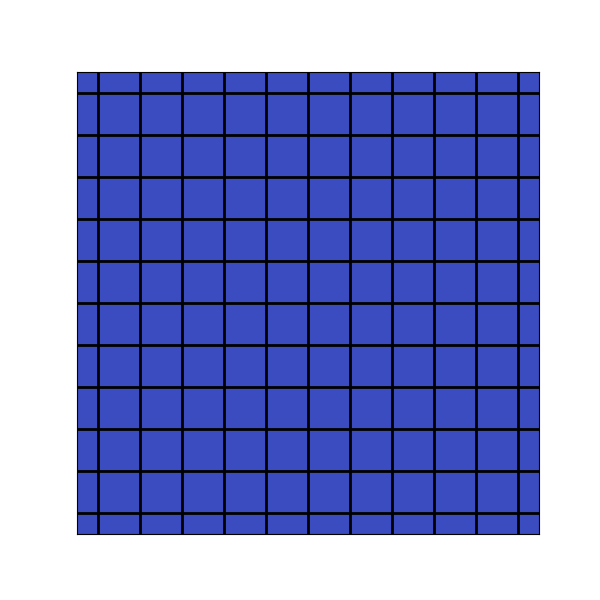

AI plays at 5, 5


In [7]:
%matplotlib widget

class InteractivePlay(object):
  def __init__(self, *, ai_player=None, ai_first=False):
    self.ai_player = ai_player
    self.position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32)
    self.ai_first = ai_first
    self.fig = None
    self.cid = None

  def _play_for_ai(self) -> Tuple[int, int]:
      ai_x, ai_y = self.ai_player(self.position, 2)
      assert self.position[ai_x, ai_y] == 0, f"AI player tried to play at {ai_x}, {ai_y} which is already taken."
      self.position[ai_x, ai_y] = 2
      print(f"AI plays at {ai_x}, {ai_y}")
      plt.plot(ai_x + 0.5, ai_y + 0.5, 'go', markersize=20)
      plt.draw()
      return ai_x, ai_y

  def update_board(self, event):
    # TODO: Handle Draw.
    x, y = int(event.xdata), int(event.ydata)
    if x < 0 or x >= BOARD_LENGTH or y < 0 or y >= BOARD_LENGTH:
        print("Out of board click. X=", x, "Y=", y)
        return
    if self.position[x, y] != 0:  # If the clicked cell is empty
        return
    
    self.position[x, y] = 1  # Place the player's piece
    print(f"Player plays at {x}, {y}")
    plt.plot(x + 0.5, y + 0.5, 'ro', markersize=20)
    plt.draw()
    # Check for win after updating the board
    if is_win(self.position, (x, y)):
        print(f"Player wins!")
        self.fig.canvas.mpl_disconnect(self.cid)  # Disable further clicks
        return

    ai_x, ai_y = self._play_for_ai()
    # Check for win after updating the board
    if is_win(self.position, (ai_x, ai_y)):
        print(f"AI wins!")
        self.fig.canvas.mpl_disconnect(self.cid)  # Disable further clicks
        return

  def display_board(self):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xticks(torch.arange(BOARD_LENGTH) + 0.5, minor=True)
    ax.set_yticks(torch.arange(BOARD_LENGTH) + 0.5, minor=True)
    ax.grid(which="minor", color="black", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(self.position, cmap='coolwarm', extent=[0, BOARD_LENGTH, 0, BOARD_LENGTH])
    plt.gca().invert_yaxis()
    self.fig = fig
    self.cid = fig.canvas.mpl_connect('button_press_event', self.update_board)
    plt.show()
    if self.ai_first:
       self._play_for_ai()


play = InteractivePlay(ai_player=greedy_play, ai_first=True)
play.display_board()

In [8]:
class NNPolicy(nn.Module):
  def __init__(self, *, one_hot=True, he_init=True):
    super(NNPolicy, self).__init__()
    self.one_hot = one_hot
    conv1_in = 3 if one_hot else 1
    self.conv1 = nn.Conv2d(conv1_in, 32, kernel_size=9, padding=4)  # parameters: 1 * 5 * 5 * 32 + 32 = 832
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)  # parameters: 64 * 5 * 5 * 64 + 64 = 51264
    self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)  # parameters: 128 * 5 * 5 * 128 + 128 = 204928
    self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)   # parameters: 256 * 3 * 3 * 256 + 256 = 590080
    self.conv_out = nn.Conv2d(256, 1, kernel_size=1)  # parameters: 1 * 1 * 256 + 1 = 257
    if he_init:
      torch.nn.init.kaiming_uniform_(self.conv1.weight, nonlinearity='relu')
      torch.nn.init.kaiming_uniform_(self.conv2.weight, nonlinearity='relu')
      torch.nn.init.kaiming_uniform_(self.conv3.weight, nonlinearity='relu')
      torch.nn.init.kaiming_uniform_(self.conv4.weight, nonlinearity='relu')
      torch.nn.init.kaiming_uniform_(self.conv_out.weight)
    # Total parameters: 832 + 51264 + 204928 + 590080 + 257 = 847361

  def forward(self, x):
    """
    Args:
      x: A LongTensor of shape [B, 1, L, L] with value 0, 1 or 2.

    Return:
      A Tensor of shape [B, L, L] for the logits to play at each position.
    """
    output_mask = torch.where(x == 0, 0, -torch.inf)
    if self.one_hot:
      x = x.squeeze(dim=1)
      space_channel = torch.where(x == 0, 1.0, 0.0)
      opponent_channel = torch.where(x == 1, 1.0, 0.0)
      player_channel = torch.where(x == 2, 1.0, 0.0)
      x = torch.stack([space_channel, opponent_channel, player_channel], dim=1)
    else:
      x = x.float()
      x = x + 1  # leave value 0 for paddings
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.conv_out(x) + output_mask
    return x.squeeze(1)
  

class PolicyPlayer(object):
  def __init__(self, policy: NNPolicy, greedy_play: bool=True):
    self.policy = policy
    self.greedy_play = greedy_play

  def play(self, position: torch.Tensor, current_player: int) -> torch.Tensor:
    self.policy.eval()
    with torch.no_grad():
      if (position != 0).all():
        return None
      assert current_player in [1, 2]
      # Always play as player 2 for simplicity.
      if current_player == 1:
        position = torch.where(position > 0, 3 - position, 0)
      position_tensor = position.view(1, 1, BOARD_LENGTH, BOARD_LENGTH)
      logits = self.policy(position_tensor)
      # softmax the last 2 dims of the output
      action_probs = F.softmax(logits.view(-1, BOARD_LENGTH * BOARD_LENGTH), dim=-1)
      if self.greedy_play:
        action_index = torch.argmax(action_probs)
      else:
        action_index = torch.multinomial(action_probs, 1)
    return torch.LongTensor([action_index // BOARD_LENGTH, action_index % BOARD_LENGTH])
  

# Test the PolicyPlayer and NNPolicy
PolicyPlayer(NNPolicy(), greedy_play=False).play(torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.int32), 1)

tensor([8, 0])

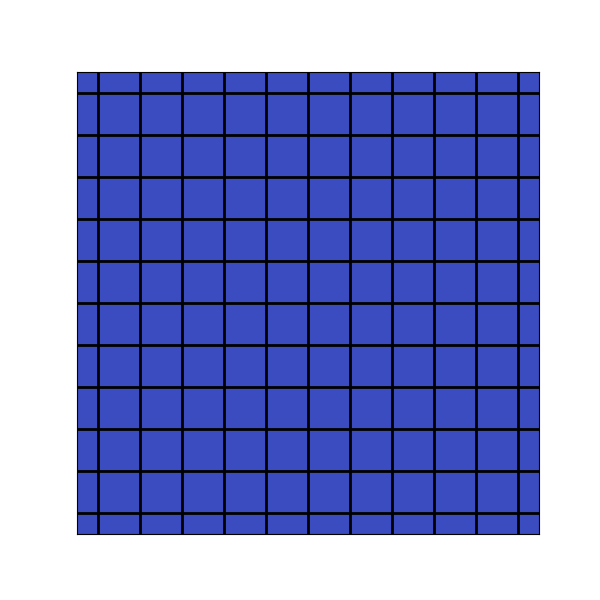

In [9]:
play = InteractivePlay(ai_player=PolicyPlayer(NNPolicy()).play)
play.display_board()

In [10]:
def scrape_player(
    policy,
    random_play=0,
  ) -> Tuple[torch.LongTensor, torch.LongTensor]:
  positions = []
  labels = []
  i = 0
  progress = tqdm(total=BOARD_LENGTH * BOARD_LENGTH * (1 + random_play))
  for i in range(BOARD_LENGTH):
    for j in range(BOARD_LENGTH):
      base_position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.long)
      base_position[i, j] = 1
      current_player = 2
      play_index = torch.LongTensor([i, j])
      stone_num = 1
      next_plays = [-1]
      if random_play:
        random_plays = np.random.choice(BOARD_LENGTH * BOARD_LENGTH, random_play, replace=False)
        next_plays.extend(random_plays)
      for next_play in next_plays:
        position = base_position.clone()
        if next_play >= 0:
          row = next_play // BOARD_LENGTH
          column = next_play % BOARD_LENGTH
          position[row, column] = 2
          current_player = 1
          play_index = torch.LongTensor([row, column])
          stone_num = 2
        progress.update()
        while stone_num < BOARD_LENGTH * BOARD_LENGTH and not is_win(position, play_index):
          play_index = policy(position, current_player)
          stone_num += 1
          # Always play as player 2 for simplicity.
          if current_player == 1:
            position_input = torch.where(position > 0, 3 - position, 0)
          else:
            position_input = position.clone()
          positions.append(position_input)
          labels.append(play_index.clone())
          position[play_index[0], play_index[1]] = current_player
          current_player = 3 - current_player
  return torch.stack(positions), torch.stack(labels)


# train_positions, train_labels = scrape_player(greedy_play, random_play=120)

In [11]:
# torch.save(train_labels, "gomoku_train_labels.pth")
# torch.save(train_positions, "gomoku_train_positions.pth")
train_positions = torch.load("gomoku_train_positions.pth")
train_labels = torch.load("gomoku_train_labels.pth")
len(train_positions)

528860

In [12]:
def train(
    policy: NNPolicy,
    train_positions: torch.Tensor,
    train_labels: torch.Tensor,
    test_split=0.01,
    lr=0.01,
    lr_warmup_steps=100,
    epochs=1,
    batch_size=512,
) -> NNPolicy:
    # train test split
    assert len(train_positions) == len(train_labels)
    train_positions = train_positions.unsqueeze(1)  # add the channel axis
    # flatten the label indices from [row, column] to a single index
    train_labels = train_labels[..., 0] * BOARD_LENGTH + train_labels[..., 1]

    N = len(train_positions)
    test_N = int(N * test_split)
    train_N = N - test_N
    perm = torch.randperm(N)
    test_indices = perm[:test_N]
    train_indices = perm[test_N:]
    test_positions = train_positions[test_indices]
    test_labels = train_labels[test_indices]
    train_positions = train_positions[train_indices]
    train_labels = train_labels[train_indices]

    policy.train()

    optimizer = torch.optim.AdamW(policy.parameters(), lr=lr)
    def lr_lambda(current_step: int):
        if current_step < lr_warmup_steps:
            return float(current_step) / float(max(1, lr_warmup_steps))
        return 1.0
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)

    for epoch in range(epochs):
        perm = torch.randperm(train_N)
        for batch_begin in range(0, train_N - batch_size, batch_size):
            batch_indices = perm[batch_begin : batch_begin + batch_size]
            batch_input = train_positions[batch_indices]
            batch_label = train_labels[batch_indices]

            optimizer.zero_grad()
            logits = policy(batch_input)
            logits = logits.view(-1, BOARD_LENGTH * BOARD_LENGTH)
            loss = F.cross_entropy(logits, target=batch_label)
            step = batch_begin // batch_size
            if epoch == 0 or step % 100 == 0:
                print(f"Epoch {epoch} step {step}: loss={loss}")
            loss.backward()

            optimizer.step()
            scheduler.step()
        test_logits = policy(test_positions)
        test_logits = test_logits.view(-1, BOARD_LENGTH * BOARD_LENGTH)
        test_loss = F.cross_entropy(test_logits, target=test_labels)
        print(f"Epoch {epoch}: test_loss={test_loss} ")

    return policy

In [13]:
trained_policy = train(
    NNPolicy(),
    train_positions,
    train_labels,
    lr_warmup_steps=100,
)

Epoch 0 step 0: loss=4.586036205291748
Epoch 0 step 1: loss=4.56203031539917
Epoch 0 step 2: loss=4.468523025512695
Epoch 0 step 3: loss=4.274061679840088
Epoch 0 step 4: loss=4.197222709655762
Epoch 0 step 5: loss=4.112507343292236
Epoch 0 step 6: loss=4.143820285797119
Epoch 0 step 7: loss=4.009322166442871
Epoch 0 step 8: loss=3.9744713306427
Epoch 0 step 9: loss=3.9788267612457275
Epoch 0 step 10: loss=3.9456231594085693
Epoch 0 step 11: loss=3.8968472480773926
Epoch 0 step 12: loss=3.8329238891601562
Epoch 0 step 13: loss=3.773167371749878
Epoch 0 step 14: loss=3.746870279312134
Epoch 0 step 15: loss=3.709662675857544
Epoch 0 step 16: loss=3.561884641647339
Epoch 0 step 17: loss=3.5512337684631348
Epoch 0 step 18: loss=3.582166910171509
Epoch 0 step 19: loss=3.5183467864990234
Epoch 0 step 20: loss=3.4856438636779785
Epoch 0 step 21: loss=3.511357069015503
Epoch 0 step 22: loss=3.604172945022583
Epoch 0 step 23: loss=3.4872615337371826
Epoch 0 step 24: loss=3.42478346824646
Epoch 

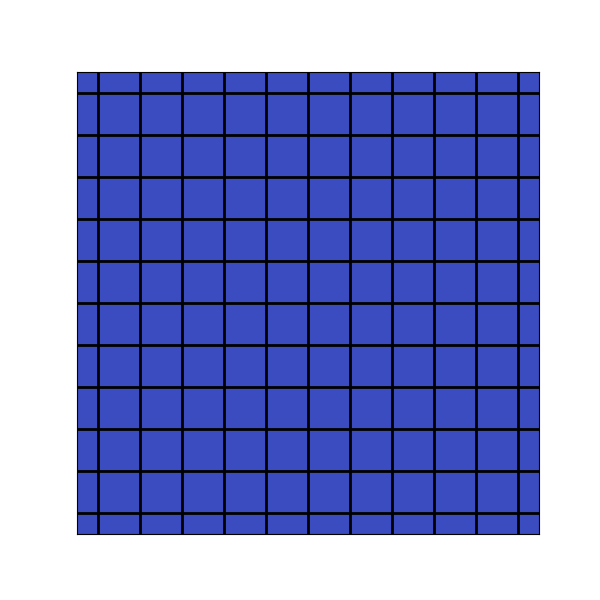

AI plays at 2, 2


In [14]:
play = InteractivePlay(
  ai_player=PolicyPlayer(trained_policy, greedy_play=False).play,
  ai_first=True,
)
play.display_board()

In [15]:
# torch.save(trained_policy.state_dict(), "gomoku_512000.pth")

## Findings from Supervised Learning
1. One-hot embedding is very important. Using a single integer to represent the board state took 10,000 steps for the loss to go down to 1.0. Using one-hot embedding took only 200 steps.
2. The model performed poorly in the later game as observed from the interactive plays. It started to ignore the 4-in-a-rows from the player's play. In the beginning, the model played well by following the greedy rule. It's not clear why the model performed poorly in the later game. It might be because the training data has a high coverage of the early games because all early games are short so they are similar. The later games are more diverse so the model might not have enough training data to learn. Another reason might be that the padding doesn't work well, and later game often happens near the border.
3. The model doesn't know where to put the first stone when it moves first. This is because the empty board state is not in the training data. We intentionally left the empty board as OOD, so that we can check if RL can get this fixed.

In [37]:
def head2head_ordered_eval(
    player1: NNPolicy,
    player2: NNPolicy,
    num_plays: int,
) -> Tuple[int, int, int]:
    win1, win2, draw = 0, 0, 0
    players = [player1, player2]

    for _ in range(num_plays):
        position = torch.zeros([BOARD_LENGTH, BOARD_LENGTH], dtype=torch.long)
        position[BOARD_LENGTH // 2, BOARD_LENGTH // 2] = 1
        current_player = 2
        play_index = torch.LongTensor([BOARD_LENGTH // 2, BOARD_LENGTH // 2])
        stone_num = 1
        while stone_num < BOARD_LENGTH * BOARD_LENGTH:
            if is_win(position, play_index):
                if current_player == 1:
                    win2 += 1
                else:
                    win1 += 1
                break
            play_index = players[current_player - 1].play(position, current_player)
            stone_num += 1
            position[play_index[0], play_index[1]] = current_player
            current_player = 3 - current_player
        if stone_num == BOARD_LENGTH * BOARD_LENGTH:
            draw += 1
    return win1, win2, draw


def head2head_eval(
    player1: NNPolicy,
    player2: NNPolicy,
    *,
    num_plays: int = 100,
    verbose_output: bool = True,
    eval_name: str = "",
) -> float:
    p1f_w1, p1f_w2, p1f_draw = head2head_ordered_eval(
        player1, player2, num_plays=num_plays
    )
    if verbose_output:
        print(
            f"Player 1 goes first: player1_wins={p1f_w1} player2_wins={p1f_w2} draw={p1f_draw}"
        )
    p2f_w2, p2f_w1, p2f_draw = head2head_ordered_eval(
        player2, player1, num_plays=num_plays
    )
    if verbose_output:
        print(
            f"Player 2 goes first: player1_wins={p2f_w1} player2_wins={p2f_w2} draw={p2f_draw}"
        )
        print(
            f"Total: player1_wins={p1f_w1 + p2f_w1} player2_wins={p1f_w2 + p2f_w2} draw={p1f_draw + p2f_draw}"
        )
    initiative_win = p1f_w1 / num_plays
    init_draw = p1f_draw / num_plays
    follow_up_win = p2f_w1 / num_plays
    follow_draw = p2f_draw / num_plays
    total_win = (p1f_w1 + p2f_w1) / (num_plays * 2)
    total_lose = (p1f_w2 + p2f_w2) / (num_plays * 2)
    print(
        f"{eval_name} init_win={initiative_win:.2%} follow_win={follow_up_win:.2%} init_draw={init_draw:.2%} follow_draw={follow_draw:.2%} total_win={total_win:.2%} total_lose={total_lose:.2%}"
    )
    return total_win


head2head_eval(
    PolicyPlayer(trained_policy, greedy_play=True),
    PolicyPlayer(trained_policy, greedy_play=False),
)

Player 1 goes first: player1_wins=93 player2_wins=6 draw=1
Player 2 goes first: player1_wins=57 player2_wins=42 draw=1
Total: player1_wins=150 player2_wins=48 draw=2
 init_win=93.00% follow_win=57.00% init_draw=1.00% follow_draw=1.00% total_win=75.00% total_lose=24.00%


0.75

In [17]:
_ = head2head_eval(
    PolicyPlayer(trained_policy, greedy_play=True),
    RuleBasedPlayer(),
    num_plays=10,
)

Player 1 goes first: player1_wins=0 player2_wins=10 draw=0
Player 2 goes first: player1_wins=0 player2_wins=10 draw=0
Total: player1_wins=0 player2_wins=20 draw=0
init_win=0.00% follow_win=0.00% init_draw=0.00% follow_draw=0.00% total_win=0.00% total_lose=100.00%


In [18]:
_ = head2head_eval(
    PolicyPlayer(trained_policy, greedy_play=False),
    RuleBasedPlayer(),
    num_plays=1000,
)

Player 1 goes first: player1_wins=308 player2_wins=691 draw=1
Player 2 goes first: player1_wins=59 player2_wins=939 draw=2
Total: player1_wins=367 player2_wins=1630 draw=3
init_win=30.80% follow_win=5.90% init_draw=0.10% follow_draw=0.20% total_win=18.35% total_lose=81.50%


## More Findings from Supervised Learning
1. The supervised learning model is significantly worse than the rule based policy. While moving first the learned model only wins 20% of the time, while moving second it wins 0%.
2. The greedy action selection happens to be not good. It loses to the rule based policy even when it moves first.

In [49]:
def self_play(
    policy: NNPolicy,
    *,
    policy_2: NNPolicy | None = None,
    draw_reward: float,
    split_reward: bool = False,
    first_player: int = 1,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    batch_logits = []
    batch_plays = []
    batch_players = []

    position = torch.zeros(size=(BOARD_LENGTH, BOARD_LENGTH), dtype=torch.long)
    current_player = first_player
    num_stones = 0
    win_player = 0
    while num_stones < BOARD_LENGTH * BOARD_LENGTH:
        # Always play as player 2 for simplicity.
        if current_player == 1:
            position_tensor = torch.where(position > 0, 3 - position, 0).detach()
        else:
            position_tensor = position.detach()
        position_tensor = position_tensor.view(1, 1, BOARD_LENGTH, BOARD_LENGTH)
        _policy = policy if current_player == 1 or not policy_2 else policy_2
        logits = _policy(position_tensor)
        flattened_logits = logits.view(BOARD_LENGTH * BOARD_LENGTH)
        flattened_probs = F.softmax(flattened_logits, dim=-1)
        to_play_flattend = torch.multinomial(flattened_probs, 1)
        to_play_i = to_play_flattend // BOARD_LENGTH
        to_play_j = to_play_flattend % BOARD_LENGTH
        if current_player == 1 or not policy_2:
            batch_logits.append(flattened_logits)
            batch_plays.append(to_play_flattend)
            batch_players.append(current_player)

        position[to_play_i, to_play_j] = current_player
        num_stones += 1
        if is_win(position, [to_play_i, to_play_j]):
            win_player = current_player
            break
        current_player = 3 - current_player
    _logits = torch.stack(batch_logits)
    _plays = torch.stack(batch_plays)
    batch_players_tensor = torch.LongTensor(batch_players)
    loss_player_stones = num_stones // 2
    win_player_stones = num_stones - loss_player_stones
    if win_player == 0:
        _rewards = (
            torch.ones_like(batch_players_tensor, dtype=torch.float) * draw_reward
        )
    elif split_reward:
        _rewards = torch.where(
            batch_players_tensor == win_player,
            1.0 / win_player_stones,
            -1.0 / loss_player_stones,
        )
    else:
        _rewards = torch.where(
            batch_players_tensor == win_player,
            1.0,
            -1.0,
        )
    return _logits, _plays, _rewards, win_player

In [53]:
def reinforcement_learn(
    base_policy: NNPolicy,
    *,
    lr: float = 0.001,
    lr_schedule: str | None = None,
    batch_size: int = 64,
    steps: int = 16,
    draw_reward: float = -0.01,
    policy_as_player2: bool = True,
    fixed_opponent_policy: NNPolicy | None = None,
    opponent_update_win_rate: float = 0.55,
) -> nn.Module:
    policy = copy.deepcopy(base_policy)
    if fixed_opponent_policy:
        base_policy = fixed_opponent_policy
    base_policy.eval()
    optimizer = torch.optim.AdamW(policy.parameters(), lr=lr)
    if not lr_schedule:
        scheduler = None
    elif lr_schedule == "cosine":
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=steps, eta_min=lr / 10
        )
    elif lr_schedule == "exponential":
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95, verbose=True)
    else:
        raise ValueError(f"Not supported lr_schedule: {lr_schedule}")

    base_policy_updates = 0
    for step in range(steps):
        all_logits = []
        all_plays = []
        all_rewards = []
        policy.train()
        init_win_num = 0
        follow_up_win_num = 0
        draw_num = 0
        for b in range(batch_size):
            if policy_as_player2:
                batch_logits, batch_plays, batch_rewards, win_player = self_play(
                    policy, draw_reward=draw_reward
                )
            else:
                first_player = b % 2 + 1
                batch_logits, batch_plays, batch_rewards, win_player = self_play(
                    policy, policy_2=base_policy, draw_reward=draw_reward, first_player=first_player,
                )
            all_logits.append(batch_logits)
            all_plays.append(batch_plays)
            all_rewards.append(batch_rewards)
            if win_player == 0:
                draw_num += 1
            elif win_player == 1 and not policy_as_player2:
                if first_player == 1:
                    init_win_num += 1
                else:
                    follow_up_win_num += 1
        step_logits = torch.concat(all_logits)  # N, BL*BL
        step_plays = torch.concat(all_plays).squeeze().detach()  # N
        step_rewards = torch.concat(all_rewards).detach()  # N
        step_loss = F.cross_entropy(step_logits, step_plays, reduction="none")
        reduced_loss = (step_loss * step_rewards).mean()

        optimizer.zero_grad()
        reduced_loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        if not policy_as_player2:
            detailed_stats = f"i{init_win_num}f{follow_up_win_num}d{draw_num}"
        else:
            detailed_stats = f"d{draw_num}"
        print(
            f"Step {step}: trained on {len(step_logits)} plays({detailed_stats}). loss={reduced_loss}"
        )
        if not policy_as_player2 and not fixed_opponent_policy:
            win_rate = head2head_eval(
                PolicyPlayer(policy, greedy_play=False),
                PolicyPlayer(base_policy, greedy_play=False),
                verbose_output=False,
                eval_name="Against base: "
            )
            if win_rate > opponent_update_win_rate:
                print(f"<--Updating base policy.-->")
                base_policy = copy.deepcopy(policy)
                base_policy.eval()
                base_policy_updates += 1
        head2head_eval(
            PolicyPlayer(policy, greedy_play=False),
            RuleBasedPlayer(),
            verbose_output=False,
            eval_name="Against rule-based player: "
        )
    print(f"RL train finished! Policy update steps = {base_policy_updates}")
    return policy

In [30]:
rl_trained_policy = reinforcement_learn(trained_policy)

Step 0: trained on 2138 plays(2 draws). loss=-0.015610440634191036
init_win=28.00% follow_win=7.00% init_draw=0.00% follow_draw=0.00% total_win=17.50% total_lose=82.50%
Step 1: trained on 2268 plays(1 draws). loss=-0.012765228748321533
init_win=42.00% follow_win=3.00% init_draw=1.00% follow_draw=0.00% total_win=22.50% total_lose=77.00%
Step 2: trained on 2378 plays(4 draws). loss=-0.023160021752119064
init_win=38.00% follow_win=4.00% init_draw=0.00% follow_draw=0.00% total_win=21.00% total_lose=79.00%
Step 3: trained on 2076 plays(0 draws). loss=0.028812702745199203
init_win=38.00% follow_win=7.00% init_draw=0.00% follow_draw=0.00% total_win=22.50% total_lose=77.50%
Step 4: trained on 2336 plays(4 draws). loss=-0.0049036587588489056
init_win=40.00% follow_win=4.00% init_draw=0.00% follow_draw=0.00% total_win=22.00% total_lose=78.00%
Step 5: trained on 2289 plays(3 draws). loss=0.004465783014893532
init_win=36.00% follow_win=4.00% init_draw=1.00% follow_draw=0.00% total_win=20.00% total

In [54]:
rl_policy_with_fixed_base = reinforcement_learn(trained_policy, steps=16, policy_as_player2=False, fixed_opponent_policy=rl_trained_policy)

Step 0: trained on 911 plays(i17f8d0). loss=-0.08534479886293411
Against rule-based player:  init_win=27.00% follow_win=6.00% init_draw=0.00% follow_draw=0.00% total_win=16.50% total_lose=83.50%
Step 1: trained on 908 plays(i16f11d0). loss=-0.1094847321510315
Against rule-based player:  init_win=29.00% follow_win=10.00% init_draw=1.00% follow_draw=0.00% total_win=19.50% total_lose=80.00%
Step 2: trained on 862 plays(i16f10d0). loss=-0.19405895471572876
Against rule-based player:  init_win=25.00% follow_win=13.00% init_draw=0.00% follow_draw=0.00% total_win=19.00% total_lose=81.00%
Step 3: trained on 853 plays(i18f5d0). loss=-0.23911930620670319
Against rule-based player:  init_win=23.00% follow_win=11.00% init_draw=0.00% follow_draw=0.00% total_win=17.00% total_lose=83.00%
Step 4: trained on 839 plays(i17f8d0). loss=-0.12057577073574066
Against rule-based player:  init_win=26.00% follow_win=15.00% init_draw=0.00% follow_draw=0.00% total_win=20.50% total_lose=79.50%
Step 5: trained on 8

In [57]:
rl_policy_with_fixed_base_32_steps = reinforcement_learn(trained_policy, steps=32, policy_as_player2=False, fixed_opponent_policy=rl_trained_policy)

Step 0: trained on 940 plays(i16f9d1). loss=-0.14727984368801117
Against rule-based player:  init_win=33.00% follow_win=5.00% init_draw=0.00% follow_draw=0.00% total_win=19.00% total_lose=81.00%
Step 1: trained on 931 plays(i16f10d0). loss=-0.14731459319591522
Against rule-based player:  init_win=29.00% follow_win=4.00% init_draw=1.00% follow_draw=0.00% total_win=16.50% total_lose=83.00%
Step 2: trained on 850 plays(i21f5d0). loss=-0.09482106566429138
Against rule-based player:  init_win=33.00% follow_win=6.00% init_draw=0.00% follow_draw=0.00% total_win=19.50% total_lose=80.50%
Step 3: trained on 778 plays(i16f7d0). loss=-0.1586965024471283
Against rule-based player:  init_win=35.00% follow_win=7.00% init_draw=0.00% follow_draw=0.00% total_win=21.00% total_lose=79.00%
Step 4: trained on 796 plays(i23f13d0). loss=0.018850214779376984
Against rule-based player:  init_win=35.00% follow_win=0.00% init_draw=0.00% follow_draw=0.00% total_win=17.50% total_lose=82.50%
Step 5: trained on 671 p

In [ ]:
# torch.save(rl_trained_policy.state_dict(), "gomoku_rl_1.pth")

In [24]:
rl_trained_policy2 = reinforcement_learn(trained_policy, batch_size=16, lr=0.0005, steps=64)

Step 0: trained on 514 plays(0 draws). loss=-0.0023458499927073717
init_win=39.00% follow_win=1.00% init_draw=0.00% follow_draw=0.00% total_win=20.00% total_lose=80.00%
Step 1: trained on 417 plays(0 draws). loss=-0.004165934398770332
init_win=31.00% follow_win=4.00% init_draw=0.00% follow_draw=0.00% total_win=17.50% total_lose=82.50%
Step 2: trained on 448 plays(0 draws). loss=-0.006782856769859791
init_win=42.00% follow_win=5.00% init_draw=0.00% follow_draw=0.00% total_win=23.50% total_lose=76.50%
Step 3: trained on 496 plays(0 draws). loss=-0.0017226762138307095
init_win=42.00% follow_win=8.00% init_draw=1.00% follow_draw=0.00% total_win=25.00% total_lose=74.50%
Step 4: trained on 432 plays(0 draws). loss=-0.0037619711365550756
init_win=33.00% follow_win=7.00% init_draw=0.00% follow_draw=0.00% total_win=20.00% total_lose=80.00%
Step 5: trained on 403 plays(0 draws). loss=-0.007504178676754236
init_win=34.00% follow_win=2.00% init_draw=0.00% follow_draw=0.00% total_win=18.00% total_l

In [52]:
head2head_eval(
    PolicyPlayer(rl_trained_policy, greedy_play=False),
    RuleBasedPlayer(),
    num_plays=1000,
)

Player 1 goes first: player1_wins=922 player2_wins=78 draw=0
Player 2 goes first: player1_wins=58 player2_wins=941 draw=1
Total: player1_wins=980 player2_wins=1019 draw=1
 init_win=92.20% follow_win=5.80% init_draw=0.00% follow_draw=0.10% total_win=49.00% total_lose=50.95%


0.49

In [55]:
head2head_eval(
    PolicyPlayer(rl_policy_with_fixed_base, greedy_play=False),
    RuleBasedPlayer(),
    num_plays=1000,
)

Player 1 goes first: player1_wins=184 player2_wins=816 draw=0
Player 2 goes first: player1_wins=215 player2_wins=785 draw=0
Total: player1_wins=399 player2_wins=1601 draw=0
 init_win=18.40% follow_win=21.50% init_draw=0.00% follow_draw=0.00% total_win=19.95% total_lose=80.05%


0.1995

In [56]:
head2head_eval(
    PolicyPlayer(rl_policy_with_fixed_base, greedy_play=False),
    PolicyPlayer(rl_trained_policy, greedy_play=False),
    num_plays=1000,
)

Player 1 goes first: player1_wins=737 player2_wins=263 draw=0
Player 2 goes first: player1_wins=415 player2_wins=585 draw=0
Total: player1_wins=1152 player2_wins=848 draw=0
 init_win=73.70% follow_win=41.50% init_draw=0.00% follow_draw=0.00% total_win=57.60% total_lose=42.40%


0.576

In [58]:
head2head_eval(
    PolicyPlayer(rl_policy_with_fixed_base_32_steps, greedy_play=False),
    PolicyPlayer(rl_trained_policy, greedy_play=False),
    num_plays=1000,
)

Player 1 goes first: player1_wins=885 player2_wins=115 draw=0
Player 2 goes first: player1_wins=552 player2_wins=447 draw=1
Total: player1_wins=1437 player2_wins=562 draw=1
 init_win=88.50% follow_win=55.20% init_draw=0.00% follow_draw=0.10% total_win=71.85% total_lose=28.10%


0.7185

In [59]:
head2head_eval(
    PolicyPlayer(rl_policy_with_fixed_base_32_steps, greedy_play=False),
    PolicyPlayer(rl_policy_with_fixed_base, greedy_play=False),
    num_plays=1000,
)

Player 1 goes first: player1_wins=542 player2_wins=458 draw=0
Player 2 goes first: player1_wins=244 player2_wins=756 draw=0
Total: player1_wins=786 player2_wins=1214 draw=0
 init_win=54.20% follow_win=24.40% init_draw=0.00% follow_draw=0.00% total_win=39.30% total_lose=60.70%


0.393

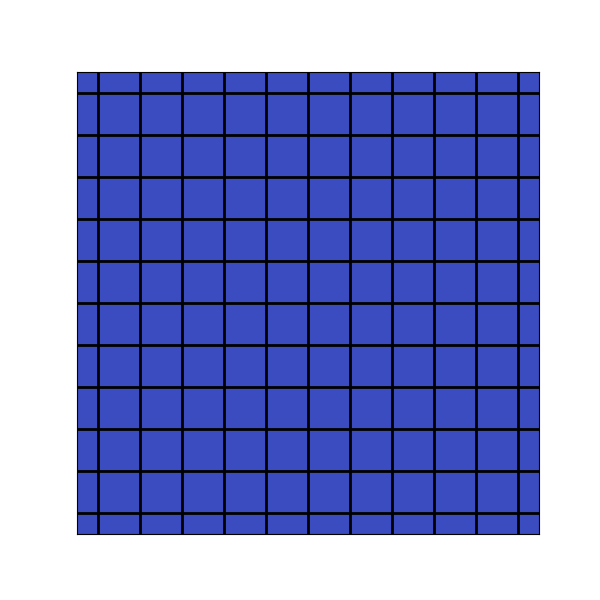

AI plays at 5, 5


Player plays at 6, 4
AI plays at 4, 4
Player plays at 6, 6
AI plays at 2, 2
Player plays at 3, 3
AI plays at 6, 5
Player plays at 4, 5
AI plays at 7, 5
Player plays at 5, 6
AI plays at 8, 5
Player plays at 9, 5
AI plays at 4, 3
Player plays at 5, 4
AI plays at 4, 1
Player plays at 3, 6
AI plays at 4, 2
Player plays at 4, 0
AI plays at 6, 3
Player plays at 4, 6
AI plays at 5, 2
Player plays at 2, 6
Player wins!


In [75]:
play = InteractivePlay(
  ai_player=PolicyPlayer(rl_policy_with_fixed_base, greedy_play=False).play,
  ai_first=True,
)
play.display_board()

## Findings from Reinforcement Learning
1. For the first try, a reward is given for the win and a penalty is given for the loss. The draw games were dropped, which caused a problem. One explanation is that the policy quickly learned to avoid losses by playing defensively. During the following self-playing, the defensive policy played against another defensive policy, which caused a very high draw game ratio and no win/lose games for the policy to continue to learn.
2. After adding a small penalty(-0.01) to both players for the draw games, the RL algorithm works pretty well. A model trained from one of the RL training runs has reached a 50% win rate against the rule based policy.
3. RL training successfully fixed the issue of the first move. The model now knows to always put the first stone in the center.
4. However, the RL training is not very stable. Only one of the many training runs achieved comparable performance as the rule-based player. Other runs have some improvement in the middle but not in the end. Only comparing with a single rule-based player is a biased evaluation, but that's the only available evaluation method for now.
5. Tried smaller learning rate, cosine / exponential learning rate decay, smaller / larger batch sizes. Still not be able to steadily converging to the high performance model.
6. Need to add some analysis if time allows, such as plotting out the activation and gradient distribution changes on each steps. After identifying the reasons of instability, things to try can be prioritized including adding norms, dropout, full connected layers, l2 regularizations, residuals, and etc. Another direction is to make the RL more efficient, by exploring MCTS, actor-critic or other more advanced RL algorithms.
7. Given a model is already trained with quality on par with the rule based model, I think the model capacity is good enough. The main goal of this notebook is to learn and show how RL works, I will first try MCTS + actor-critic, and then go back to stability if it's still an issue.

## Some other findings with regards to the stability:
1. Tried removed split reward by number of stones. Got another good model by luck. Stability is still an issue.
2. Introduced a base model as opponent in self-play as the Alpha-go setup. The policy plays with a fixed base model which is a snapshot of itself. The backprop only goes to the policy model that is on one side of each play as opposed to both side in the case where the opponent is also the plolicy itself. This process is expected to be more stable since the model only get updated when it's better than itself. However, in practice the finding is that the target policy might be updated to a stage where it always becomes worse after each step, so that the base model never gets updated.
3. Tried to use the first successful RL policy (rl_trained_policy) as a fixed opponent to learn another policy(rl_policy_with_fixed_base). Head2head results showed some circular wins
   - rule_based_policy wins rl_policy_with_fixed_base by 80.05%
   - rl_policy_with_fixed_base wins rl_trained_policy by 57.6%
   - rl_trained_policy ties rule_based_policy
   This means that a policy can be trained to beat a specific opponent, but it's not guaranteed to be better than other policies. This reveals 2 issues of the current LR setting:
   1) Using one fixe rule base policy for the h2h evaluation is likely pretty biased.
   2) By only evolving the self-paly to one direction, the policy might become stronger against the base policy for every iteration but weaker and weaker against other policies on average.
   Question, is there an optimal policy for Gomoku that can win any other policy? If there is, what RL setup can find it? 